<a href="https://colab.research.google.com/github/opablon/Sliding-puzzle/blob/main/Puzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from time import sleep
import random
from PIL import Image, ImageDraw
import requests
from io import BytesIO
import heapq
from IPython.display import display, update_display

FUNCIÓN: **CARGAR Y PREPARAR LA IMAGEN**

In [ ]:
def cargar_imagen(url_o_ruta, tamano, REDIMENSION_IMAGEN):
    """
    Carga una imagen (desde URL o ruta), la recorta a un cuadrado,
    la redimensiona y la divide en n*n piezas.
    """
    if url_o_ruta.startswith('http'):
        respuesta = requests.get(url_o_ruta)
        imagen = Image.open(BytesIO(respuesta.content))
    else:
        imagen = Image.open(url_o_ruta)

    lado_minimo = min(imagen.size)
    imagen = imagen.crop((0, 0, lado_minimo, lado_minimo))
    imagen = imagen.resize(REDIMENSION_IMAGEN)

    piezas = []
    ancho_pieza = imagen.width // tamano
    alto_pieza = imagen.height // tamano

    for i in range(tamano):
        for j in range(tamano):
            izquierda = j * ancho_pieza
            superior = i * alto_pieza
            derecha = izquierda + ancho_pieza
            inferior = superior + alto_pieza

            pieza = imagen.crop((izquierda, superior, derecha, inferior))
            piezas.append(pieza)

    tupla_tamano_pieza = (ancho_pieza, alto_pieza)

    return imagen, piezas, tupla_tamano_pieza

*FUNCIÓN*: **CREAR ESTADO OBJETIVO**

In [ ]:
def crear_mapas_y_estados(tamano, lista_piezas, tamano_pieza):
    """
    Crea los mapeos de número->imagen y número->posición_objetivo.
    """
    mapa_piezas = {}
    mapa_objetivo = {}
    objetivo_numerico = []

    num_pieza = 1
    for f in range(tamano):
        fila = []
        for c in range(tamano):
            if f == tamano - 1 and c == tamano - 1:
                # Caso especial: la última pieza (abajo a la derecha) es el espacio vacío
                fila.append(ESPACIO_VACIO)
                mapa_piezas[ESPACIO_VACIO] = Image.new('RGB', tamano_pieza, color='black')
                mapa_objetivo[ESPACIO_VACIO] = (f, c)
            else:
                # Caso normal: todas las demás piezas
                fila.append(num_pieza)
                mapa_piezas[num_pieza] = lista_piezas[num_pieza - 1]
                mapa_objetivo[num_pieza] = (f, c)
                num_pieza += 1
        objetivo_numerico.append(fila)

    estado_objetivo_tupla = tuple(tuple(fila) for fila in objetivo_numerico)
    return mapa_piezas, mapa_objetivo, estado_objetivo_tupla

*FUNCIÓN*: **MEZCLAR PUZZLE**

In [ ]:
def mezclar_puzzle(estado_objetivo, num_movimientos, semilla_aleatoria):
    """
    Mezcla el puzzle realizando una caminata aleatoria desde el estado objetivo.
    Evita movimientos que deshacen el movimiento anterior.
    """
    print("\nMezclando piezas...")
    random.seed(semilla_aleatoria)

    estado_actual = estado_objetivo
    ultimo_movimiento = None
    opuestos = {'ARRIBA': 'ABAJO', 'ABAJO': 'ARRIBA', 'IZQUIERDA': 'DERECHA', 'DERECHA': 'IZQUIERDA'}

    for _ in range(num_movimientos):
        sucesores = generar_sucesores(estado_actual)

        # Filtra el movimiento opuesto al último realizado
        if ultimo_movimiento:
            movimiento_opuesto = opuestos[ultimo_movimiento]
            sucesores_filtrados = [s for s in sucesores if s[1] != movimiento_opuesto]

            # Solo usa la lista filtrada si no nos deja sin opciones
            if sucesores_filtrados:
                sucesores = sucesores_filtrados

        # Elige un movimiento al azar
        nuevo_estado, ultimo_movimiento = random.choice(sucesores)
        estado_actual = nuevo_estado

    return estado_actual

FUNCIÓN: **ENCONTRAR PIEZA VACÍA**

In [ ]:
def encontrar_vacio(estado):
    """
    Encuentra la posición (fila, columna) del espacio vacío (ESPACIO_VACIO).
    """
    tamano = len(estado)
    for f in range(tamano):
        for c in range(tamano):
            if estado[f][c] == ESPACIO_VACIO:
                return f, c
    return -1, -1

FUNCIÓN: **GENERAR MOVIMIENTOS POSIBLES**

In [ ]:
def generar_sucesores(estado):
    """
    Genera todos los estados sucesores válidos (numéricos).
    """
    tamano = len(estado)
    f_vacio, c_vacio = encontrar_vacio(estado)
    sucesores = []
    movimientos = [
        (-1, 0, 'ARRIBA'), (1, 0, 'ABAJO'),
        (0, -1, 'IZQUIERDA'), (0, 1, 'DERECHA')
    ]

    for df, dc, nombre in movimientos:
        nueva_f, nueva_c = f_vacio + df, c_vacio + dc

        if 0 <= nueva_f < tamano and 0 <= nueva_c < tamano:
            lista_estado = [list(fila) for fila in estado]

            # Intercambio
            lista_estado[f_vacio][c_vacio] = lista_estado[nueva_f][nueva_c]
            lista_estado[nueva_f][nueva_c] = ESPACIO_VACIO

            nuevo_estado = tuple(tuple(fila) for fila in lista_estado)
            sucesores.append((nuevo_estado, nombre))
    return sucesores

FUNCIÓN: **DIBUJAR EL PUZZLE EN PANTALLA**

In [ ]:
def construir_estado_imagen(estado, mapa_piezas, tamano_pieza):
    """
    Construye una imagen PIL a partir de un estado NUMÉRICO.
    """
    tamano = len(estado)
    ancho_pieza, alto_pieza = tamano_pieza
    ancho_total = ancho_pieza * tamano
    alto_total = alto_pieza * tamano

    lienzo = Image.new('RGB', (ancho_total, alto_total))
    dibujo = ImageDraw.Draw(lienzo)

    for idx_f, fila in enumerate(estado):
        for idx_c, num_pieza in enumerate(fila):
            pos_x = idx_c * ancho_pieza
            pos_y = idx_f * alto_pieza

            img_pieza = mapa_piezas[num_pieza]

            lienzo.paste(img_pieza, (pos_x, pos_y))

            # Dibuja el borde
            dibujo.rectangle(
                [pos_x, pos_y, pos_x + ancho_pieza - 1, pos_y + alto_pieza - 1],
                outline='black',
                width=1
            )
    return lienzo

FUNCIÓN: **APLICAR UN MOVIMIENTO**

In [ ]:
def aplicar_movimiento(estado, movimiento):
    """
    Aplica un movimiento a un estado numérico, reutilizando la lógica
    de 'generar_sucesores' para evitar duplicar código.
    """
    # Genera todos los movimientos válidos desde el estado actual
    for nuevo_estado, nombre_movimiento in generar_sucesores(estado):

        # Si el movimiento generado coincide con el que queremos aplicar...
        if nombre_movimiento == movimiento:

            # ...devuelve ese nuevo estado.
            return nuevo_estado

    # Si el movimiento no se encontró (no era válido), devuelve el estado original
    return estado

FUNCIÓN: **RESOLVER CON BFS**

In [ ]:
def resolver_puzzle_bfs(estado_inicial, estado_objetivo):
    """
    Resuelve el puzzle usando BFS.
    """
    if estado_inicial == estado_objetivo:
        return []

    cola = deque([(estado_inicial, [])])
    visitados = {estado_inicial}

    print("Buscando solución con BFS...")
    while cola:
        estado_actual, ruta_actual = cola.popleft()
        for nuevo_estado, movimiento in generar_sucesores(estado_actual):
            if nuevo_estado not in visitados:
                visitados.add(nuevo_estado)
                nueva_ruta = ruta_actual + [movimiento]
                if nuevo_estado == estado_objetivo:
                    print(f"\nSolución encontrada. Estados explorados: {len(visitados)}")
                    return nueva_ruta
                cola.append((nuevo_estado, nueva_ruta))
                if len(visitados) % 5000 == 0:
                    print(f"Estados explorados: {len(visitados)}...")
    return None

FUNCIÓN: **HEURÍSTICA DE MANHATTAN**

In [ ]:
def heuristica_manhattan(estado_actual, posiciones_objetivo):
    """
    Calcula la distancia Manhattan usando números y el mapa pre-calculado.
    """
    tamano = len(estado_actual)
    distancia_total = 0
    for f_actual in range(tamano):
        for c_actual in range(tamano):
            num_pieza = estado_actual[f_actual][c_actual]
            if num_pieza != ESPACIO_VACIO: # Ignora el ESPACIO_VACIO
                f_obj, c_obj = posiciones_objetivo[num_pieza]
                distancia_total += abs(f_actual - f_obj) + abs(c_actual - c_obj)
    return distancia_total

FUNCIÓN: **RESOLVER CON A***

In [ ]:
def resolver_puzzle_a_estrella(estado_inicial, estado_objetivo, mapa_objetivo):
    """
    Resuelve el puzzle usando A* y la heurística de Manhattan.
    Utiliza un mapa de objetivos pre-calculado para mayor eficiencia.
    """
    if estado_inicial == estado_objetivo:
        return []

    costo_g_inicial = 0
    costo_total_inicial = costo_g_inicial + heuristica_manhattan(estado_inicial, mapa_objetivo)

    contador = 0
    frontera = [
        (costo_total_inicial, contador, costo_g_inicial, estado_inicial, [])
    ]
    costo_g_registrado = {estado_inicial: costo_g_inicial}

    print("Buscando solución con A*...")
    while frontera:
        _, _, costo_g_actual, estado_actual, ruta_actual = heapq.heappop(frontera)

        if estado_actual == estado_objetivo:
            print(f"\nSolución encontrada. Estados explorados: {len(costo_g_registrado)}")
            return ruta_actual

        if costo_g_actual > costo_g_registrado.get(estado_actual, float('inf')):
            continue

        for nuevo_estado, movimiento in generar_sucesores(estado_actual):
            nuevo_costo_g = costo_g_actual + 1
            if nuevo_costo_g < costo_g_registrado.get(nuevo_estado, float('inf')):
                costo_g_registrado[nuevo_estado] = nuevo_costo_g
                nuevo_costo_total = nuevo_costo_g + heuristica_manhattan(nuevo_estado, mapa_objetivo)
                contador += 1
                heapq.heappush(frontera, (nuevo_costo_total, contador, nuevo_costo_g, nuevo_estado, ruta_actual + [movimiento]))

                if len(costo_g_registrado) % 5000 == 0:
                     print(f"Estados explorados (A*): {len(costo_g_registrado)}...")
    return None

In [ ]:
ESPACIO_VACIO = 0 # Constante para representar el espacio vacío
TAMANO_PUZZLE = 4
MOVIMIENTOS = 50
URL_IMAGEN = "https://blog.jumboprinters.com/wp-content/uploads/2021/09/consejos-imagenes.jpg"
ALGORITMO = 'A*'   # 'BFS', 'A*' o None para selección automática
REDIMENSION_IMAGEN = (300, 300)   # Tamaño de la imagen del puzzle
REDIMENSION_GRAFICO = (4, 4)    # Tamaño del gráfico de la imagen original
PAUSA_ANIMACION = 0.4   # Velocidad de la animación
GUARDAR_GIF = False     # Guarda la animación como 'solucion.gif'
SEMILLA_ALEATORIA = 2025

FUNCIÓN: **PRINCIPAL**


Cargando y dividiendo imagen para un puzzle de 4x4...

Mezclando piezas...


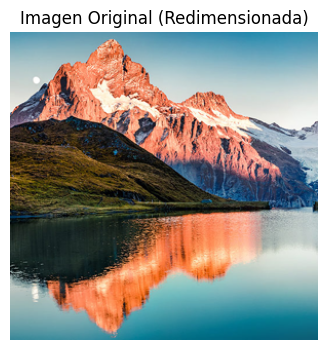


Estado Inicial (Estático):


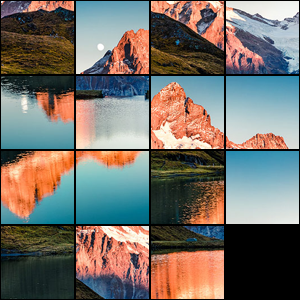


Estado Objetivo (Referencia):


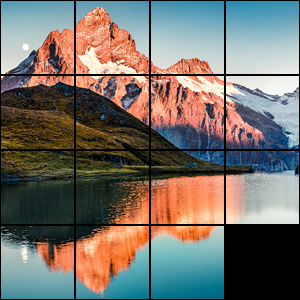


Algoritmo seleccionado: A*

Buscando solución con A*...
Estados explorados (A*): 5000...
Estados explorados (A*): 10000...
Estados explorados (A*): 15000...
Estados explorados (A*): 20000...
Estados explorados (A*): 25000...
Estados explorados (A*): 30000...
Estados explorados (A*): 35000...
Estados explorados (A*): 40000...
Estados explorados (A*): 45000...
Estados explorados (A*): 50000...
Estados explorados (A*): 55000...
Estados explorados (A*): 60000...
Estados explorados (A*): 65000...
Estados explorados (A*): 70000...
Estados explorados (A*): 75000...
Estados explorados (A*): 80000...
Estados explorados (A*): 80000...
Estados explorados (A*): 85000...
Estados explorados (A*): 90000...
Estados explorados (A*): 95000...
Estados explorados (A*): 100000...
Estados explorados (A*): 105000...
Estados explorados (A*): 110000...
Estados explorados (A*): 115000...
Estados explorados (A*): 120000...
Estados explorados (A*): 125000...
Estados explorados (A*): 130000...
Estados explorados 

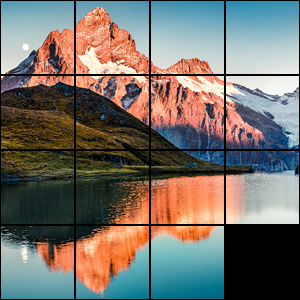


--- FIN ANIMACIÓN ---

Movimientos realizados (38 en total):
  Paso 1: IZQUIERDA
  Paso 2: ARRIBA
  Paso 3: IZQUIERDA
  Paso 4: ARRIBA
  Paso 5: DERECHA
  Paso 6: ARRIBA
  Paso 7: DERECHA
  Paso 8: ABAJO
  Paso 9: ABAJO
  Paso 10: IZQUIERDA
  Paso 11: IZQUIERDA
  Paso 12: ABAJO
  Paso 13: DERECHA
  Paso 14: DERECHA
  Paso 15: ARRIBA
  Paso 16: IZQUIERDA
  Paso 17: IZQUIERDA
  Paso 18: ABAJO
  Paso 19: IZQUIERDA
  Paso 20: ARRIBA
  Paso 21: ARRIBA
  Paso 22: ARRIBA
  Paso 23: DERECHA
  Paso 24: ABAJO
  Paso 25: DERECHA
  Paso 26: ARRIBA
  Paso 27: DERECHA
  Paso 28: ABAJO
  Paso 29: IZQUIERDA
  Paso 30: ABAJO
  Paso 31: IZQUIERDA
  Paso 32: ABAJO
  Paso 33: IZQUIERDA
  Paso 34: ARRIBA
  Paso 35: DERECHA
  Paso 36: DERECHA
  Paso 37: ABAJO
  Paso 38: DERECHA


In [ ]:
print(f"Cargando y dividiendo imagen para un puzzle de {TAMANO_PUZZLE}x{TAMANO_PUZZLE}...")
try:
    if TAMANO_PUZZLE > 4:
        print(f"\nADVERTENCIA: Un puzzle de {TAMANO_PUZZLE}x{TAMANO_PUZZLE} es computacionalmente muy complejo.")
        print("El algoritmo de búsqueda puede tardar mucho tiempo o agotar la memoria.\n")
    if TAMANO_PUZZLE > 3 and ALGORITMO == 'BFS':
        print(f"\nADVERTENCIA: BFS no es recomendable para puzzles mayores a 3x3. Usa 'A*'.\n")

    imagen_completa, piezas_completas, tupla_tamano_pieza = cargar_imagen(URL_IMAGEN, TAMANO_PUZZLE, REDIMENSION_IMAGEN)
    mapa_piezas, mapa_objetivo, estado_objetivo = crear_mapas_y_estados(TAMANO_PUZZLE, piezas_completas, tupla_tamano_pieza)
    estado_inicial = mezclar_puzzle(estado_objetivo, MOVIMIENTOS, SEMILLA_ALEATORIA)

    plt.figure(figsize=REDIMENSION_GRAFICO)
    plt.imshow(np.array(imagen_completa))
    plt.title("Imagen Original (Redimensionada)")
    plt.axis('off')
    plt.show()

    imagen_inicial_pil = construir_estado_imagen(estado_inicial, mapa_piezas, tupla_tamano_pieza)
    imagen_objetivo_pil = construir_estado_imagen(estado_objetivo, mapa_piezas, tupla_tamano_pieza)

    print("\nEstado Inicial (Estático):")
    display(imagen_inicial_pil)
    print("\nEstado Objetivo (Referencia):")
    display(imagen_objetivo_pil)

    solucion = None

    if ALGORITMO == None and TAMANO_PUZZLE < 4:
        print("\nSeleccionando algoritmo de búsqueda automáticamente...")
        ALGORITMO = 'BFS'
    elif ALGORITMO == None and TAMANO_PUZZLE > 3:
        print("\nSeleccionando algoritmo de búsqueda automáticamente...")
        ALGORITMO = 'A*'

    print(f"\nAlgoritmo seleccionado: {ALGORITMO}\n")

    if ALGORITMO == 'BFS':
        solucion = resolver_puzzle_bfs(estado_inicial, estado_objetivo)
    elif ALGORITMO == 'A*' or (ALGORITMO == None and TAMANO_PUZZLE > 3):
        solucion = resolver_puzzle_a_estrella(estado_inicial, estado_objetivo, mapa_objetivo)


    if solucion is not None:
        print(f"\nSolución encontrada en {len(solucion)} movimientos. Mostrando animación...")

        controlador_display = display(imagen_inicial_pil, display_id=True)
        estado_actual_anim = estado_inicial

        fotogramas = [imagen_inicial_pil]
        sleep(1.0)

        for movimiento in solucion:
            sleep(PAUSA_ANIMACION)

            estado_actual_anim = aplicar_movimiento(estado_actual_anim, movimiento)

            img_paso_actual = construir_estado_imagen(estado_actual_anim, mapa_piezas, tupla_tamano_pieza)

            fotogramas.append(img_paso_actual)
            controlador_display.update(img_paso_actual)

        print("\n--- FIN ANIMACIÓN ---")

        if GUARDAR_GIF:
            print("Guardando animación como 'solucion.gif'...")
            fotogramas[0].save(
                'solucion.gif',
                save_all=True,
                append_images=fotogramas[1:],
                duration=int(PAUSA_ANIMACION * 1000),
                loop=0
            )
            print("¡GIF guardado!")

        print(f"\nMovimientos realizados ({len(solucion)} en total):")
        for i, movimiento in enumerate(solucion):
            print(f"  Paso {i+1}: {movimiento}")

    else:
        print("No se encontró solución.")

except Exception as e:
    print(f"Error: {e}")